**Table of contents**<a id='toc0_'></a>    
- [탐색적 데이터 분석](#toc1_)    
  - [데이터 둘러보기](#toc1_1_)    
    - [feature 요약표 만들기](#toc1_1_1_)    
  - [데이터 시각화](#toc1_2_)    
    - [타겟 값 분포](#toc1_2_1_)    
    - [이진 피처 분포](#toc1_2_2_)    
    - [명목형 피처 분포](#toc1_2_3_)    
      - [step1. 교차분석표 생성 함수 만들기](#toc1_2_3_1_)    
      - [step2. 포인트플롯 생성 함수 만들기](#toc1_2_3_2_)    
      - [step3. 피처 분포도 및 피처별 타겟값 1의 비율 포인트플롯 생성 함수 만들기](#toc1_2_3_3_)    
    - [순서형 피처 분포](#toc1_2_4_)    
    - [날짜 피처 분포](#toc1_2_5_)    
- [베이스라인 모델](#toc2_)    
  - [피처 엔지니어링](#toc2_1_)    
    - [원-핫 인코딩](#toc2_1_1_)    
    - [데이터 나누기](#toc2_1_2_)    
  - [모델 훈련](#toc2_2_)    
  - [모델 성능 검증](#toc2_3_)    
- [성능 개선 1](#toc3_)    
  - [feature engineering 1: feature 맞춤 인코딩](#toc3_1_)    
    - [이진 피처 인코딩](#toc3_1_1_)    
    - [순서형 피처 인코딩](#toc3_1_2_)    
    - [명목형 피처 인코딩](#toc3_1_3_)    
    - [날짜 피처 인코딩](#toc3_1_4_)    
  - [feature engineering 2: 피처 스케일링](#toc3_2_)    
    - [순서형 피처 스케일링](#toc3_2_1_)    
    - [인코딩 및 스케일링된 피처 합치기](#toc3_2_2_)    
    - [데이터 나누기](#toc3_2_3_)    
  - [하이퍼파라미터 최적화](#toc3_3_)    
  - [모델 성능 검증](#toc3_4_)    
- [성능 개선 2](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

[캐글의 categorical feature encoding challenge](https://www.kaggle.com/competitions/cat-in-the-dat/data)

# <a id='toc1_'></a>[탐색적 데이터 분석](#toc0_)


In [1]:
import pandas as pd

In [ ]:
data_path = './data/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

## <a id='toc1_1_'></a>[데이터 둘러보기](#toc0_)

In [3]:
train.shape, test.shape

((300000, 24), (200000, 23))

In [4]:
train.head().T

id,0,1,2,3,4
bin_0,0,0,0,0,0
bin_1,0,1,0,1,0
bin_2,0,0,0,0,0
bin_3,T,T,F,F,F
bin_4,Y,Y,Y,Y,N
nom_0,Green,Green,Blue,Red,Red
nom_1,Triangle,Trapezoid,Trapezoid,Trapezoid,Trapezoid
nom_2,Snake,Hamster,Lion,Snake,Lion
nom_3,Finland,Russia,Russia,Canada,Canada
nom_4,Bassoon,Piano,Theremin,Oboe,Oboe


In [ ]:
submission.head()

,target
id,
300000,0.5
300001,0.5
300002,0.5
300003,0.5
300004,0.5


### <a id='toc1_1_1_'></a>[feature 요약표 만들기](#toc0_)

In [8]:
def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values
    
    return summary

resumetable(train)

데이터셋 형상: (300000, 24)


,피처,dtypes,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,bin_0,int64,0,2,0,0,0
1,bin_1,int64,0,2,0,1,0
2,bin_2,int64,0,2,0,0,0
3,bin_3,object,0,2,T,T,F
4,bin_4,object,0,2,Y,Y,Y
5,nom_0,object,0,3,Green,Green,Blue
6,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
7,nom_2,object,0,6,Snake,Hamster,Lion
8,nom_3,object,0,6,Finland,Russia,Russia
9,nom_4,object,0,4,Bassoon,Piano,Theremin


In [9]:
for i in range(3):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


In [10]:
for i in range(3, 6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'ih' 'IK' 'Ob' 'RP' 'dN' 'us' 'dZ' 'yN' 'Nf' 'QM' 'jV' 'sY' 'wu' 'SB'
 'UO' 'Mx' 'JX' 'Ry' 'Uk' 'uJ' 'LE' 'ps' 'kE' 'MO' 'kw' 'yY' 'zU' 'bJ'
 'Kf' 'ck' 'mb' '

In [ ]:
print('day 고윳값:', train['day'].unique())
print('month 고윳값:', train['month'].unique())
print('target 고윳값:', train['target'].unique())

day 고윳값: [2 7 5 4 3 1 6]
month 고윳값: [ 2  8  1  4 10  3  7  9 12 11  5  6]
target 고윳값: [0 1]


## <a id='toc1_2_'></a>[데이터 시각화](#toc0_)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

### <a id='toc1_2_1_'></a>[타겟 값 분포](#toc0_)

Text(0.5, 1.0, 'target 분포')

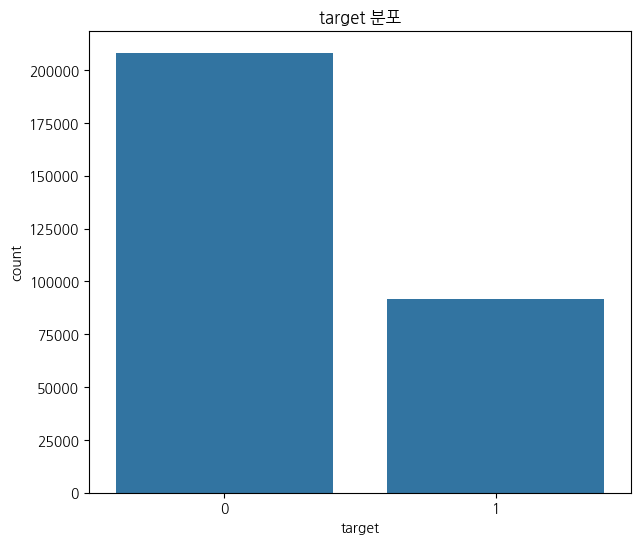

In [ ]:
plt.figure(figsize=(7, 6))

sns.countplot(data=train, x='target')
plt.title('target 분포')

### <a id='toc1_2_2_'></a>[이진 피처 분포](#toc0_)

In [21]:
def write_percent(ax, total_size):
    '''
    도형 객체를 순회하며 막대 상단에 타겟값 비율 표시
    '''
    for patch in ax.patches:
        height = patch.get_height() # 도형 높이(데이터 개수)
        width = patch.get_width()
        left_coord = patch.get_x() # 도형 왼쪽 좌표
        percentage = height/total_size*100 # 타겟값 비율
        
        ax.text(left_coord + width/2.0, # x축 위치
                height + total_size*0.001, # y축 위치
                f'{percentage:.2f}%', # 입력 텍스트
                ha='center') # 텍스트 가운데 정렬

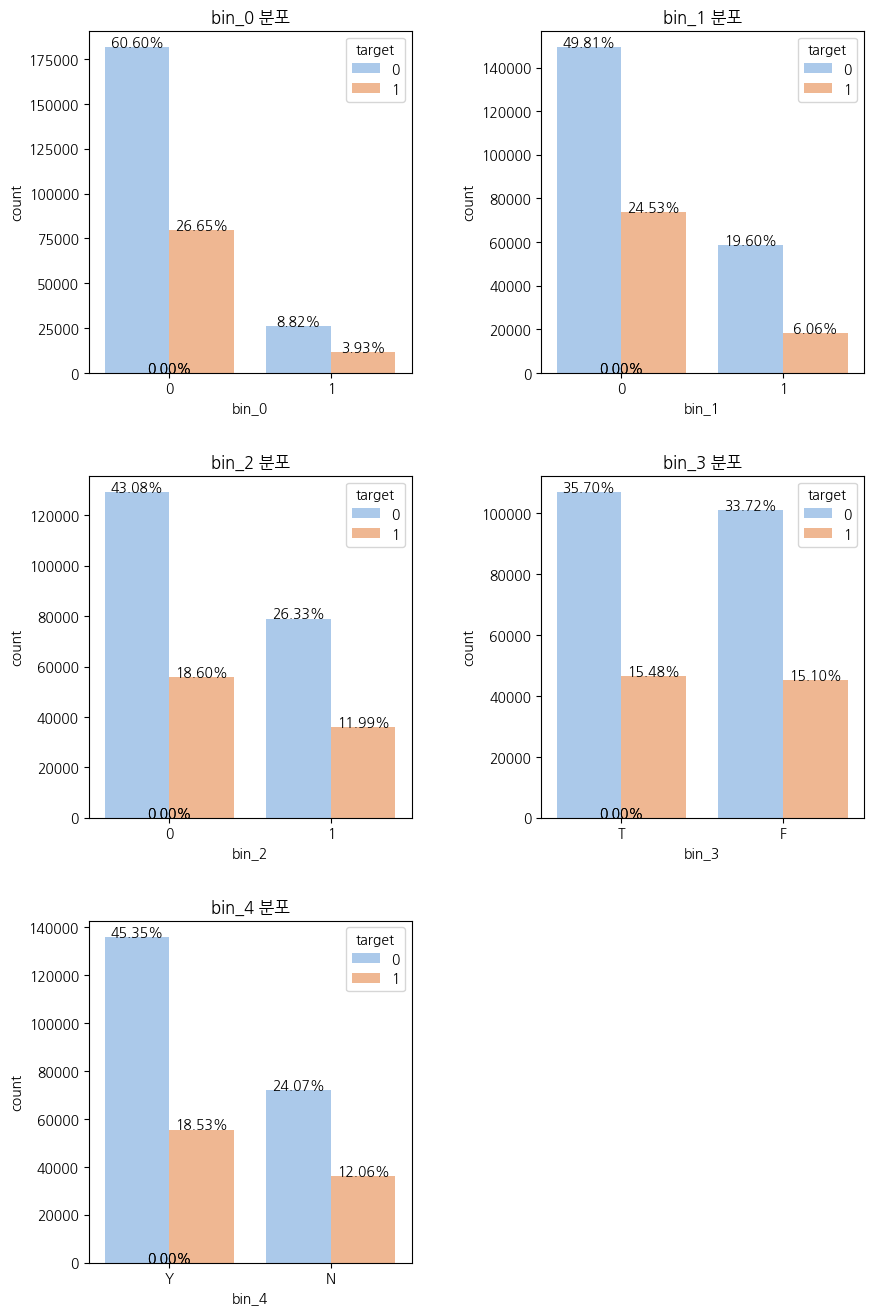

In [ ]:
import matplotlib.gridspec as gridspec

grid = gridspec.GridSpec(3, 2, wspace=0.4, hspace=0.3) # 3행 2열 틀(Figure) 준비
plt.figure(figsize=(10, 16))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

for idx, feature in enumerate(bin_features):
    ax = plt.subplot(grid[idx])
    
    sns.countplot(x=feature, 
                  data=train, 
                  hue='target', 
                  palette='pastel', ax=ax)
    
    ax.set_title(f'{feature} 분포')
    write_percent(ax, len(train))

### <a id='toc1_2_3_'></a>[명목형 피처 분포](#toc0_)

#### <a id='toc1_2_3_1_'></a>[step1. 교차분석표 생성 함수 만들기](#toc0_)

교차표 혹은 교차분석표(cross-tabulation)
- 범주형 데이터 2개를 비교 분석하는 데 사용되는 표
- 각 범주형 데이터의 빈도나 통계량을 행과 열로 결합해놓은 표

In [25]:
# normalize 옵션 : 'index', 'column'
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index') # 인덱스를 기준으로 정규화
crosstab

target,0,1
nom_0,,
Blue,0.758210,0.241790
Green,0.672855,0.327145
Red,0.648948,0.351052


In [26]:
crosstab = crosstab.reset_index()
crosstab

target,nom_0,0,1
0,Blue,0.758210,0.241790
1,Green,0.672855,0.327145
2,Red,0.648948,0.351052


In [34]:
# 위의 과정을 함수로 만들어 놓음
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    
    return crosstab

In [ ]:
crosstab = get_crosstab(train, 'nom_0')
crosstab

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


#### <a id='toc1_2_3_2_'></a>[step2. 포인트플롯 생성 함수 만들기](#toc0_)

In [ ]:
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab, 
                        order=crosstab[feature].values, # 포인트플롯 순서
                        color='black', 
                        legend=False)
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1)
    ax2.set_ylabel('타겟 1 비율(%)')

#### <a id='toc1_2_3_3_'></a>[step3. 피처 분포도 및 피처별 타겟값 1의 비율 포인트플롯 생성 함수 만들기](#toc0_)

In [40]:
def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols, size=(15, 20)):
    plt.figure(figsize=size)
    grid=gridspec.GridSpec(num_rows, num_cols, wspace=0.45, hspace=0.3)
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature)
        
        sns.countplot(x=feature, data=df, 
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)
        
        write_percent(ax, len(df))
        plot_pointplot(ax, feature, crosstab) 
        ax.set_title(f'{feature} 분포 및 타겟 1 비율')

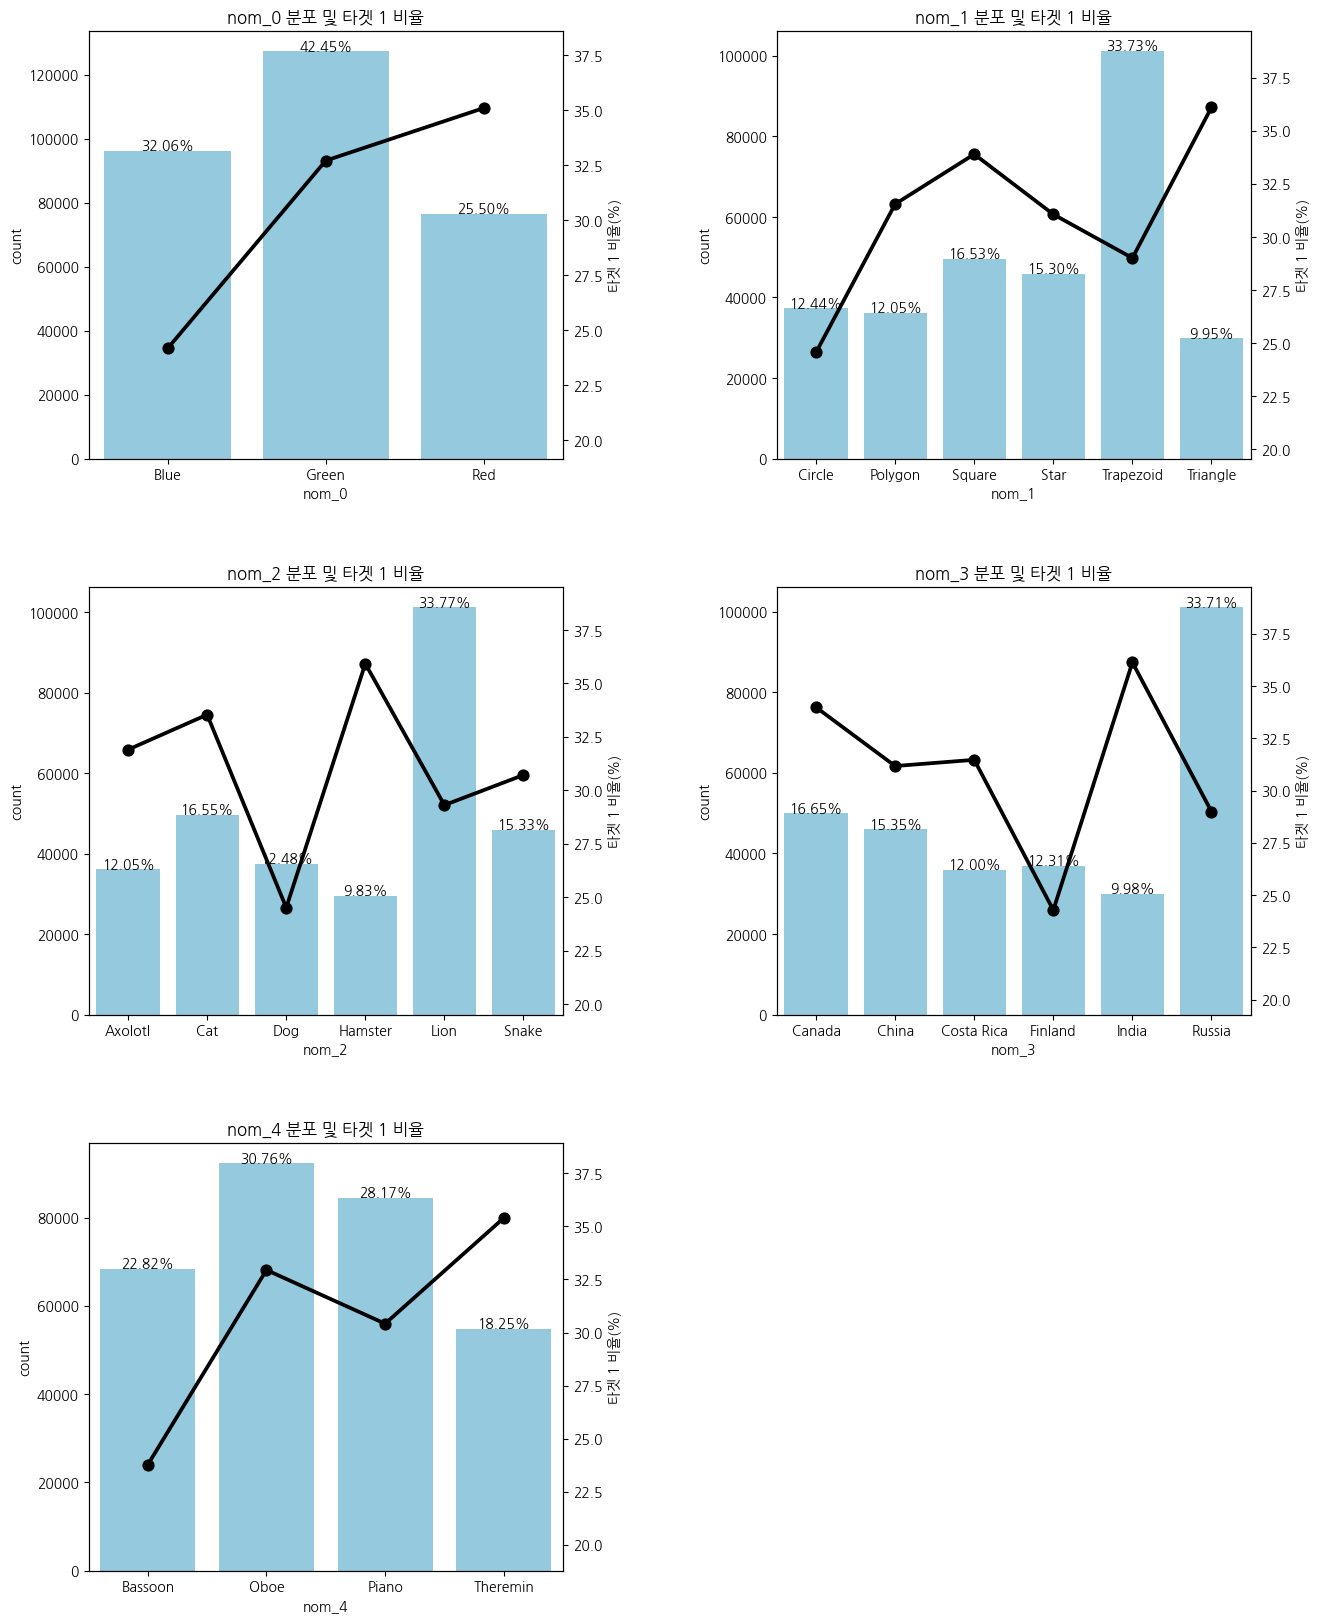

In [ ]:
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
plot_cat_dist_with_true_ratio(train, nom_features, 3, 2)

### <a id='toc1_2_4_'></a>[순서형 피처 분포](#toc0_)

In [47]:
from pandas.api.types import CategoricalDtype

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

# 데이터 타입 변경 -> 피처 자체에 순서를 지정
train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

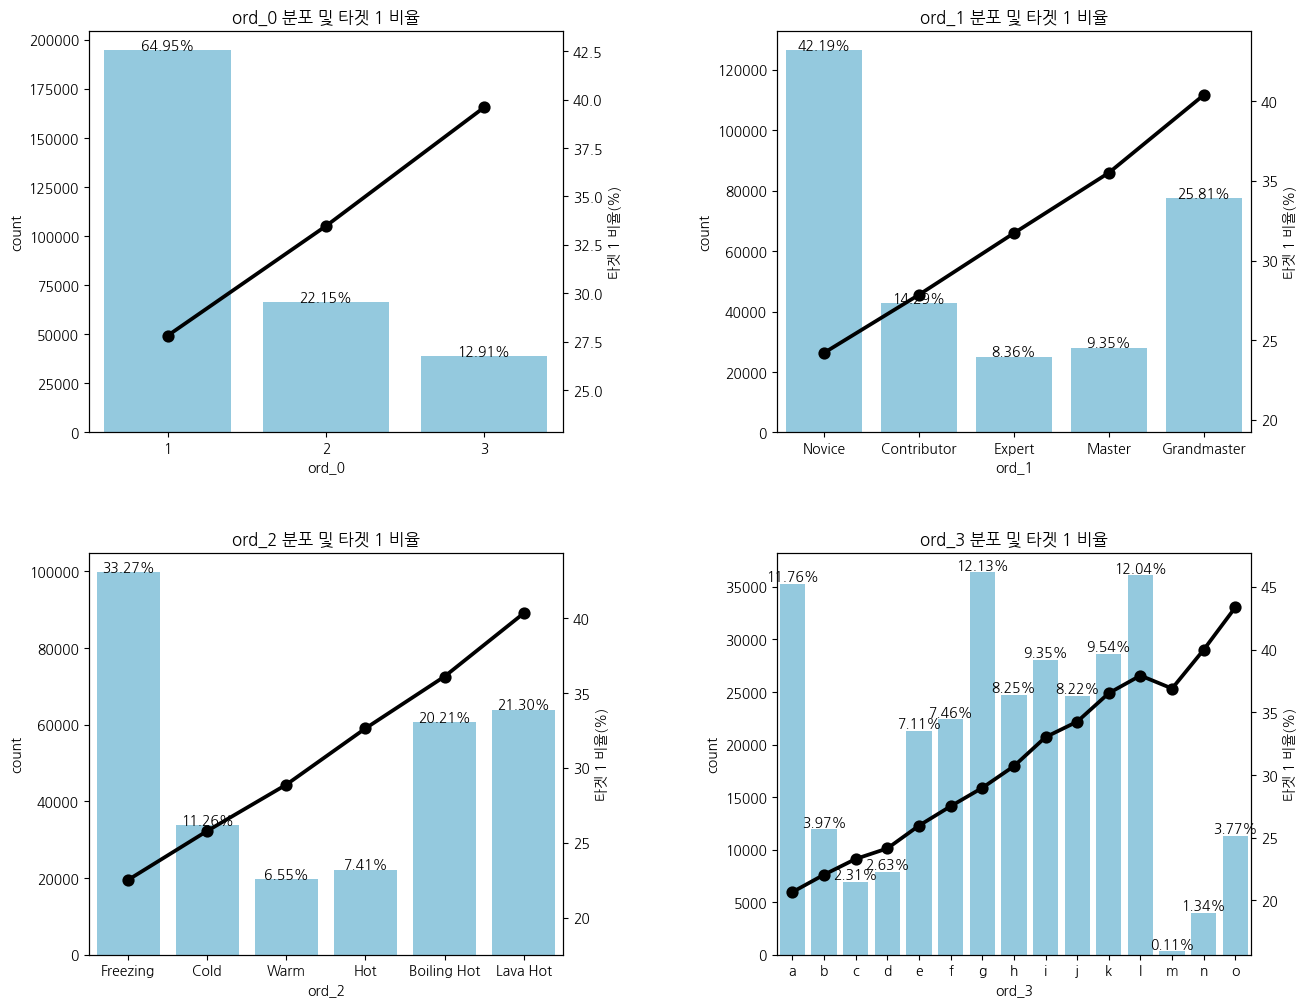

In [48]:
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3']
plot_cat_dist_with_true_ratio(train, ord_features, 2, 2, size=(15, 12))

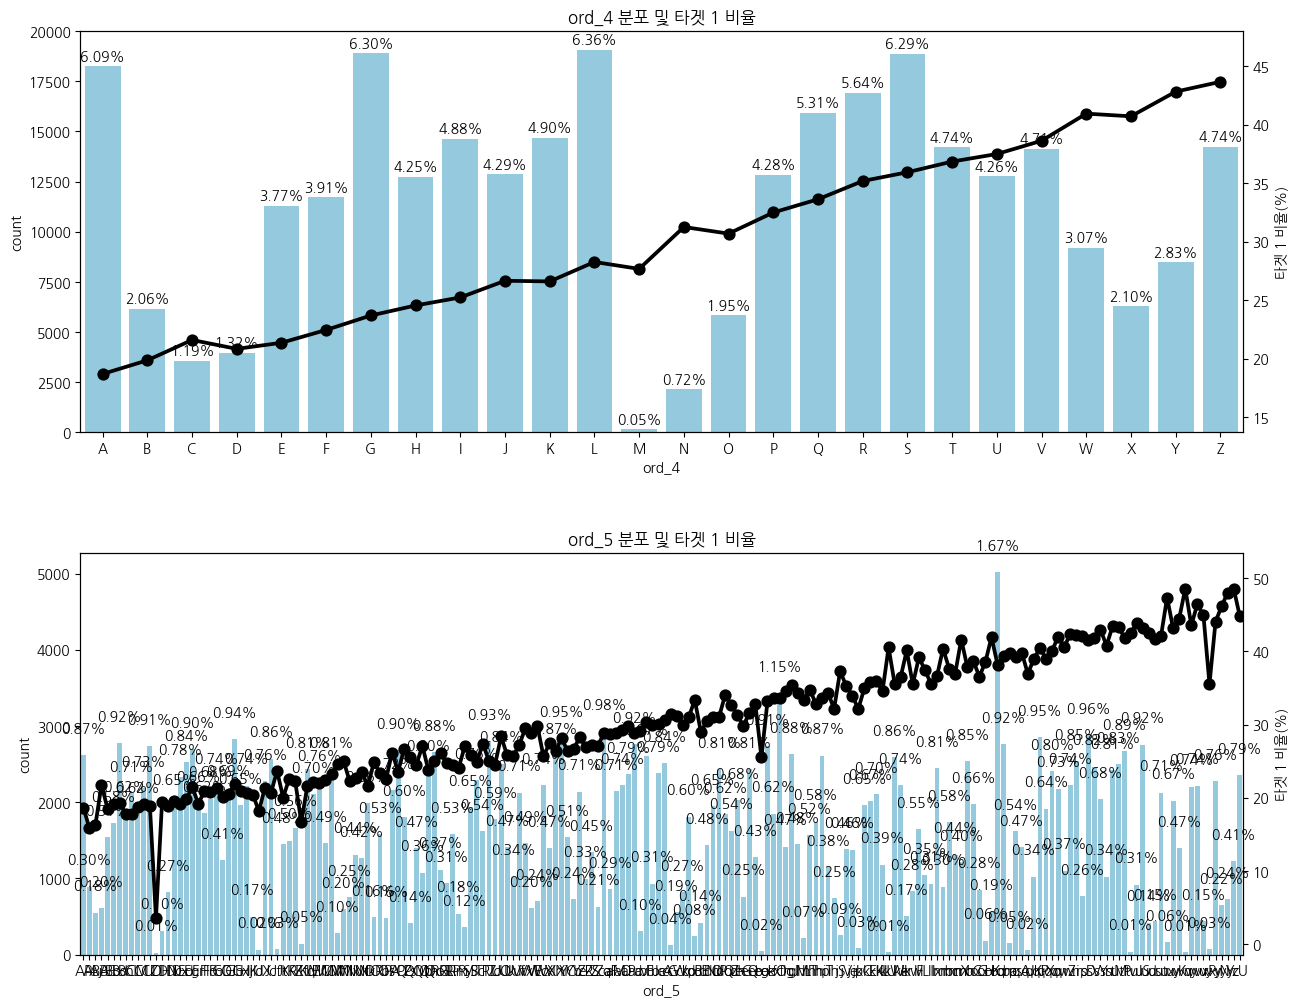

In [49]:
plot_cat_dist_with_true_ratio(train, ['ord_4', 'ord_5'], 2, 1, size=(15, 12))

- 순서형 피처 모두 고윳값 순서에 따라 타겟값이 1인 비율이 증가함
- 모든 그래프에서 순서와 비율 사이에 상관관계가 있으므로 순서형 피처 중에서도 필요 없는 피처는 없어 보임

### <a id='toc1_2_5_'></a>[날짜 피처 분포](#toc0_)

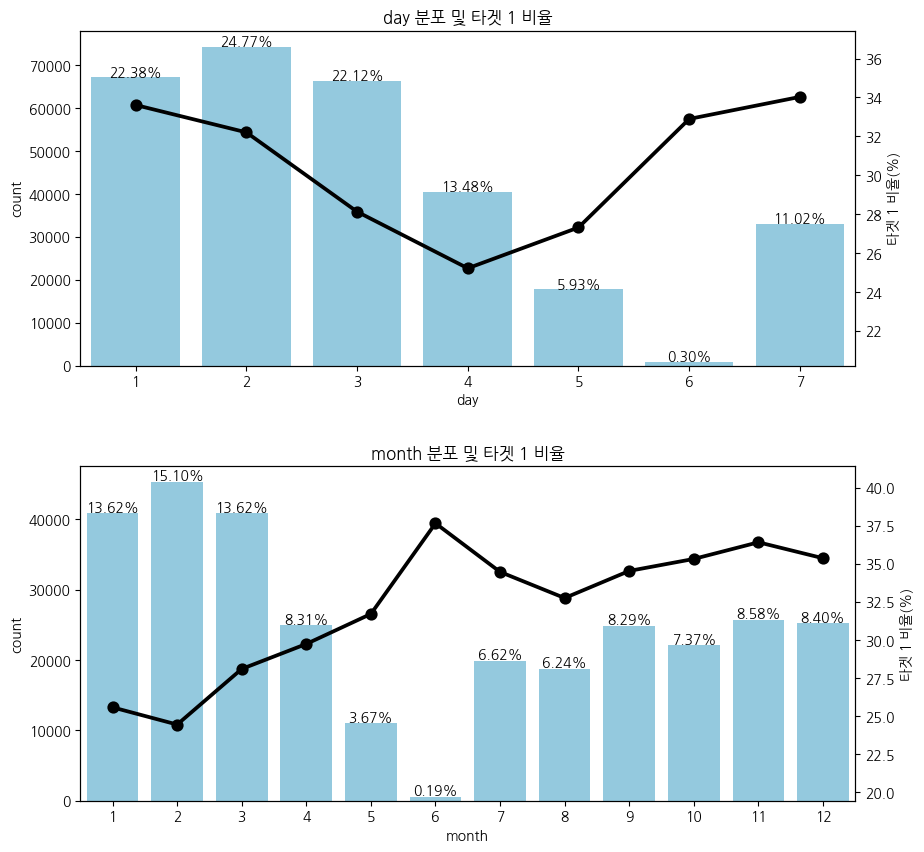

In [50]:
date_features = ['day', 'month']
plot_cat_dist_with_true_ratio(train, date_features, 2, 1, size=(10, 10))

- 머신러닝 모델은 숫자 값을 가치의 크고 작음으로 해석함
- 12와 1의 차이가 11이나 됨
- 이럴 때 삼각함수(sin, cos)를 사용해 인코딩하면 시작과 끝이 매끄럽게 연결되어 문제가 해결됨
    - 매년, 매월, 매주, 매일 반복되느 ㄴ데이터를 순환형 데이터라고 부름
    - 계절, 월, 요일, 시간 등이 이에 속함
    - 요일과 월 피처는 원-핫 인코딩을 적용하는 게 성능이 더 좋을수도

# <a id='toc2_'></a>[베이스라인 모델](#toc0_)

## <a id='toc2_1_'></a>[피처 엔지니어링](#toc0_)

In [ ]:
# 훈련 데이터와 테스트 데이터에 동일한 인코딩을 적용하기 위해 데이터셋을 합침
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1)
all_data

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,0,F,N,Green,Square,Lion,Canada,Theremin,...,9e4b23160,acc31291f,1,Novice,Lava Hot,j,A,Gb,1,3
499996,1,0,0,F,Y,Green,Trapezoid,Lion,China,Piano,...,cfbd87ed0,eae3446d0,1,Contributor,Lava Hot,f,S,Ed,2,2
499997,0,1,1,T,Y,Green,Trapezoid,Lion,Canada,Oboe,...,1108bcd6c,33dd3cf4b,1,Novice,Boiling Hot,g,V,TR,3,1


### <a id='toc2_1_1_'></a>[원-핫 인코딩](#toc0_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
all_data_encoded = encoder.fit_transform(all_data)

### <a id='toc2_1_2_'></a>[데이터 나누기](#toc0_)

In [53]:
num_train = len(train)

X_train = all_data_encoded[:num_train]
X_test = all_data_encoded[num_train:]

y = train['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, 
                                                      test_size=0.1, 
                                                      stratify=y,
                                                      random_state=42)   

## <a id='toc2_2_'></a>[모델 훈련](#toc0_)

- max_iter: 모델의 회귀 계수를 업데이트하는 반복 횟수

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## <a id='toc2_3_'></a>[모델 성능 검증](#toc0_)

- predict() 타겟값 자체(0, 1)를 예측
- predict_proba() 타겟값의 확률(0일 확률, 1일 확률)을 예측

In [58]:
y_valid_preds = logistic_model.predict_proba(X_valid)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC: {roc_auc:.6f}')

검증 데이터 ROC AUC: 0.794972


# <a id='toc3_'></a>[성능 개선 1](#toc0_)

1. feature 맞춤 인코딩
2. 피처 스케일링
3. 하이퍼파라미터 최적화 

## <a id='toc3_1_'></a>[feature engineering 1: feature 맞춤 인코딩](#toc0_)

In [ ]:
# train, test 데이터 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) 

### <a id='toc3_1_1_'></a>[이진 피처 인코딩](#toc0_)

- bin_3, bin_4 feature는 각각 T와 F,  Y와 N이라는 문자로 구성돼 있음 -> 1과 0으로 인코딩

In [ ]:
all_data['bin_3'] = all_data['bin_3'].map({'F': 0, 'T': 1})
all_data['bin_4'] = all_data['bin_4'].map({'N': 0, 'Y': 1})

### <a id='toc3_1_2_'></a>[순서형 피처 인코딩](#toc0_)

In [62]:
ord1dict = {'Novice': 0, 'Contributor': 1, 'Expert': 2, 'Master': 3, 'Grandmaster': 4}
ord2dict = {'Freezing': 0, 'Cold': 1, 'Warm': 2, 'Hot': 3, 'Boiling Hot': 4, 'Lava Hot': 5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder()
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(f'{feature} 고윳값: {categories}')

ord_3 고윳값: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4 고윳값: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5 고윳값: ['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' '

### <a id='toc3_1_3_'></a>[명목형 피처 인코딩](#toc0_)

- 명목형 피처는 순서를 무시해도 되기 때문에 원-핫 인코딩을 적용

In [66]:
nom_features = ['nom_' + str(i) for i in range(10)]

In [67]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])
encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

희소행렬을 CSR 형식으로 반환
- 희소행렬를 COO 형식이나 CSR 형식으로 표현하면 메모리 낭비를 줄일 수 있음
- 그 중 CSR 형식이 메모리를 더 적게 쓰면서 연산도 빠름 -> CSR 형식을 더 많이 씀

In [ ]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제

### <a id='toc3_1_4_'></a>[날짜 피처 인코딩](#toc0_)

In [ ]:
date_features = ['day', 'month']

encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])
all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제
encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

## <a id='toc3_2_'></a>[feature engineering 2: 피처 스케일링](#toc0_)

- 서로 다른 피처들의 값의 범위가 일치하도록 조정하는 작업
- 앞에서 이진, 명목형, 날짜 피처를 모두 0과 1로 인코딩했음. 순서형 피처는 여전히 여러 가지 값을 가지고 있으므로 순서형 피처의 값 범위도 0-1 사이가 되도록 스케일링

### <a id='toc3_2_1_'></a>[순서형 피처 스케일링](#toc0_)

- 다른 피처들과 범위를 맞추기 위해 순서형 피처에 min-max 정규화 적용

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)]  
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

### <a id='toc3_2_2_'></a>[인코딩 및 스케일링된 피처 합치기](#toc0_)

all_data 데이터프레임, encoded_nom_matrix, encoded_date_matrix CSR 형식의 행렬을 합침

In [71]:
from scipy import sparse
# hstack : 행렬을 수평방향으로 합침, default format='coo
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data), 
                               encoded_nom_matrix, 
                               encoded_date_matrix], format='csr')

In [72]:
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

- 이 정도 크기를 DataFrame으로 처리하면 메모리 낭비가 심하고 훈련 속도도 떨어짐. 
- DataFrame으로 변환하지 않고, CSR 형식 그대로 사용

### <a id='toc3_2_3_'></a>[데이터 나누기](#toc0_)

In [73]:
num_train = len(train)

X_train = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

## <a id='toc3_3_'></a>[하이퍼파라미터 최적화](#toc0_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

# 하이퍼파라미터 값 목록
lr_params = {'C': [0.1, 0.125, 0.2], 'max_iter': [800, 900, 1000],
             'solver': ['liblinear'], 'random_state':[42]}

gridsearch_logistic_model = GridSearchCV(logistic_model, 
                                         lr_params,
                                         scoring='roc_auc',
                                         cv=5)

gridsearch_logistic_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)

최적 하이퍼파라미터: {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}


## <a id='toc3_4_'></a>[모델 성능 검증](#toc0_)

In [76]:
y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(f'검증 데이터 ROC AUC: {roc_auc:.6f}')

검증 데이터 ROC AUC: 0.804529


# <a id='toc4_'></a>[성능 개선 2](#toc0_)

훈련 데이터의 10%를 검증용으로만 사용하니 조금 아까움 -> 훈련 데이터 전체를 사용해 모델을 훈련